In [1]:
import pandas as pd
from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean
from mlforecast.target_transforms import Differences
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from numba import njit
from typing import List
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS
)

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [3]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

In [4]:
df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

##### exponential weighted moving:
$\alpha = \frac{2}{(span+1)}$

$\alpha=.3 \rightarrow span=5.67$

##### expending mean:
- performs a given operation (like sum, mean, etc.) considering all data points up to the current one

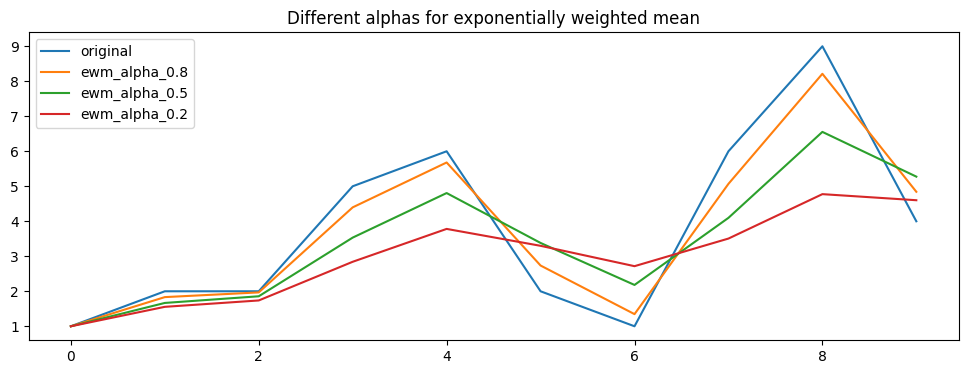

In [5]:
# Sample data
data = {
    'original': [1, 2, 2, 5, 6, 2, 1, 6, 9, 4]
}
dff = pd.DataFrame(data)

# Apply ewm with alpha=0.3
dff['ewm_alpha_0.8'] = dff['original'].ewm(alpha=0.8).mean()
dff['ewm_alpha_0.5'] = dff['original'].ewm(alpha=0.5).mean()
dff['ewm_alpha_0.2'] = dff['original'].ewm(alpha=0.2).mean()

plt.figure(figsize=(12, 4))
plt.plot(dff)
plt.legend(dff.columns)
plt.title('Different alphas for exponentially weighted mean')
plt.show()

In [6]:
# to be even faster, one can exploit numba:

@njit
def rolling_mean_6(x):
    return rolling_mean(x, window_size=6)

In [7]:
# Instantiate the MLForecast object and decide on some pre-processing/feature creation

mlf = MLForecast(
    models=[LGBMRegressor(), XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='MS',  # Frequency of the data - 'M' for monthly frequency
    lags=list(range(1, 3)),  # Specific lags to use as regressors: 1 to 6 
    target_transforms=[Differences([1])],    
    lag_transforms = {
        1: [(expanding_mean), (rolling_mean, 6), (rolling_mean_6), (ewm_mean, .3)]
        #2:  [expanding_mean],  # Apply expanding mean transformation to the lag of 2 month
        #3: [rolling_mean, 6] # Doing something using lag3...
    },
    date_features=['year', 'month', 'quarter'],  # Date features to use as regressors
)

In [8]:
# observe some preprocessing:

dfx = mlf.preprocess(df_nixtla)

dfx.head(3)

,unique_id,ds,y,lag1,lag2,expanding_mean_lag1,rolling_mean_lag1_window_size6,rolling_mean_6_lag1,ewm_mean_lag1_alpha0.3,year,month,quarter
7,01BEL,2019-08-01,-0.12286,-1.68236,-0.11784,0.033633,0.033633,0.033633,-0.342053,2019,8,3
8,01BEL,2019-09-01,-0.91985,-0.12286,-1.68236,0.011277,0.046307,0.046307,-0.276295,2019,9,3
9,01BEL,2019-10-01,0.00000,-0.91985,-0.12286,-0.105114,-0.187667,-0.187667,-0.469362,2019,10,4


In [9]:
# fit models:

model = mlf.fit(df_nixtla, fitted=True, 
                prediction_intervals=PredictionIntervals(n_windows=12)
               )

In [10]:
fcst_mlf_df = model.predict(12, level=[90]) # forecast of 12 months

In [11]:
fcst_mlf_df.sample(10)

,unique_id,ds,LGBMRegressor,XGBRegressor,LinearRegression,LGBMRegressor-lo-90,LGBMRegressor-hi-90,XGBRegressor-lo-90,XGBRegressor-hi-90,LinearRegression-lo-90,LinearRegression-hi-90
6313,72LM1,2023-01-01,299.868239,306.381317,297.806334,298.083600,301.652878,304.322027,308.440607,291.134085,304.478584
2447,32MIR,2023-11-01,2.154941,0.742485,22.890677,-1.024475,5.334357,-2.266672,3.751641,16.801956,28.979398
387,06MON,2023-03-01,53.814557,52.294552,62.419565,49.002464,58.626650,47.849789,56.739315,52.700409,72.138721
6529,75DAU,2023-01-01,203.492173,212.392029,203.519667,156.530195,250.454151,163.822209,260.961848,131.051006,275.988327
2758,34LUN,2023-10-01,17.494373,17.389429,35.406516,15.939035,19.049711,15.324978,19.453880,28.482584,42.330449
5909,68WIT,2023-05-01,36.820861,36.049076,46.988782,18.705212,54.936509,19.096810,53.001342,27.387608,66.589957
7858,84PER,2023-10-01,53.518766,52.235996,71.575252,52.401299,54.636234,50.783553,53.688440,64.750992,78.399512
2278,31CAS,2023-10-01,6.403744,4.551398,26.490374,-6.634470,19.441958,-7.636925,16.739720,15.112508,37.868240
8416,92ASN,2023-04-01,32.951211,32.681683,45.046157,16.643366,49.259055,16.796669,48.566696,20.775501,69.316813
1025,13M12,2023-05-01,16.713246,16.484989,28.196479,8.792588,24.633904,7.336771,25.633208,13.611552,42.781405


In [12]:
# Instantiate the StatsForecast class
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='MS',  # The frequency of the time series data 
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

<Axes: xlabel='ds'>

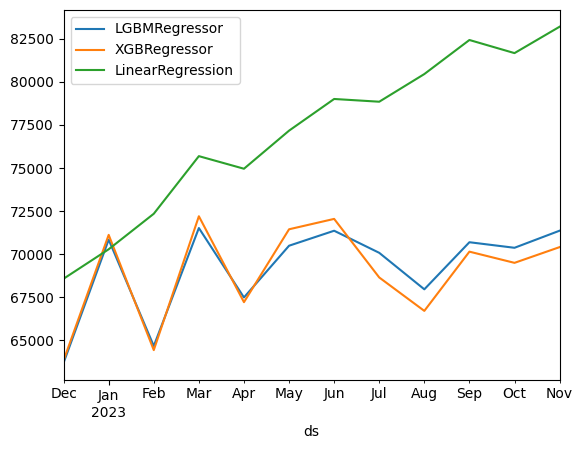

In [13]:
fcst_mlf_df.groupby('ds')[['LGBMRegressor', 'XGBRegressor', 'LinearRegression']].sum().plot()

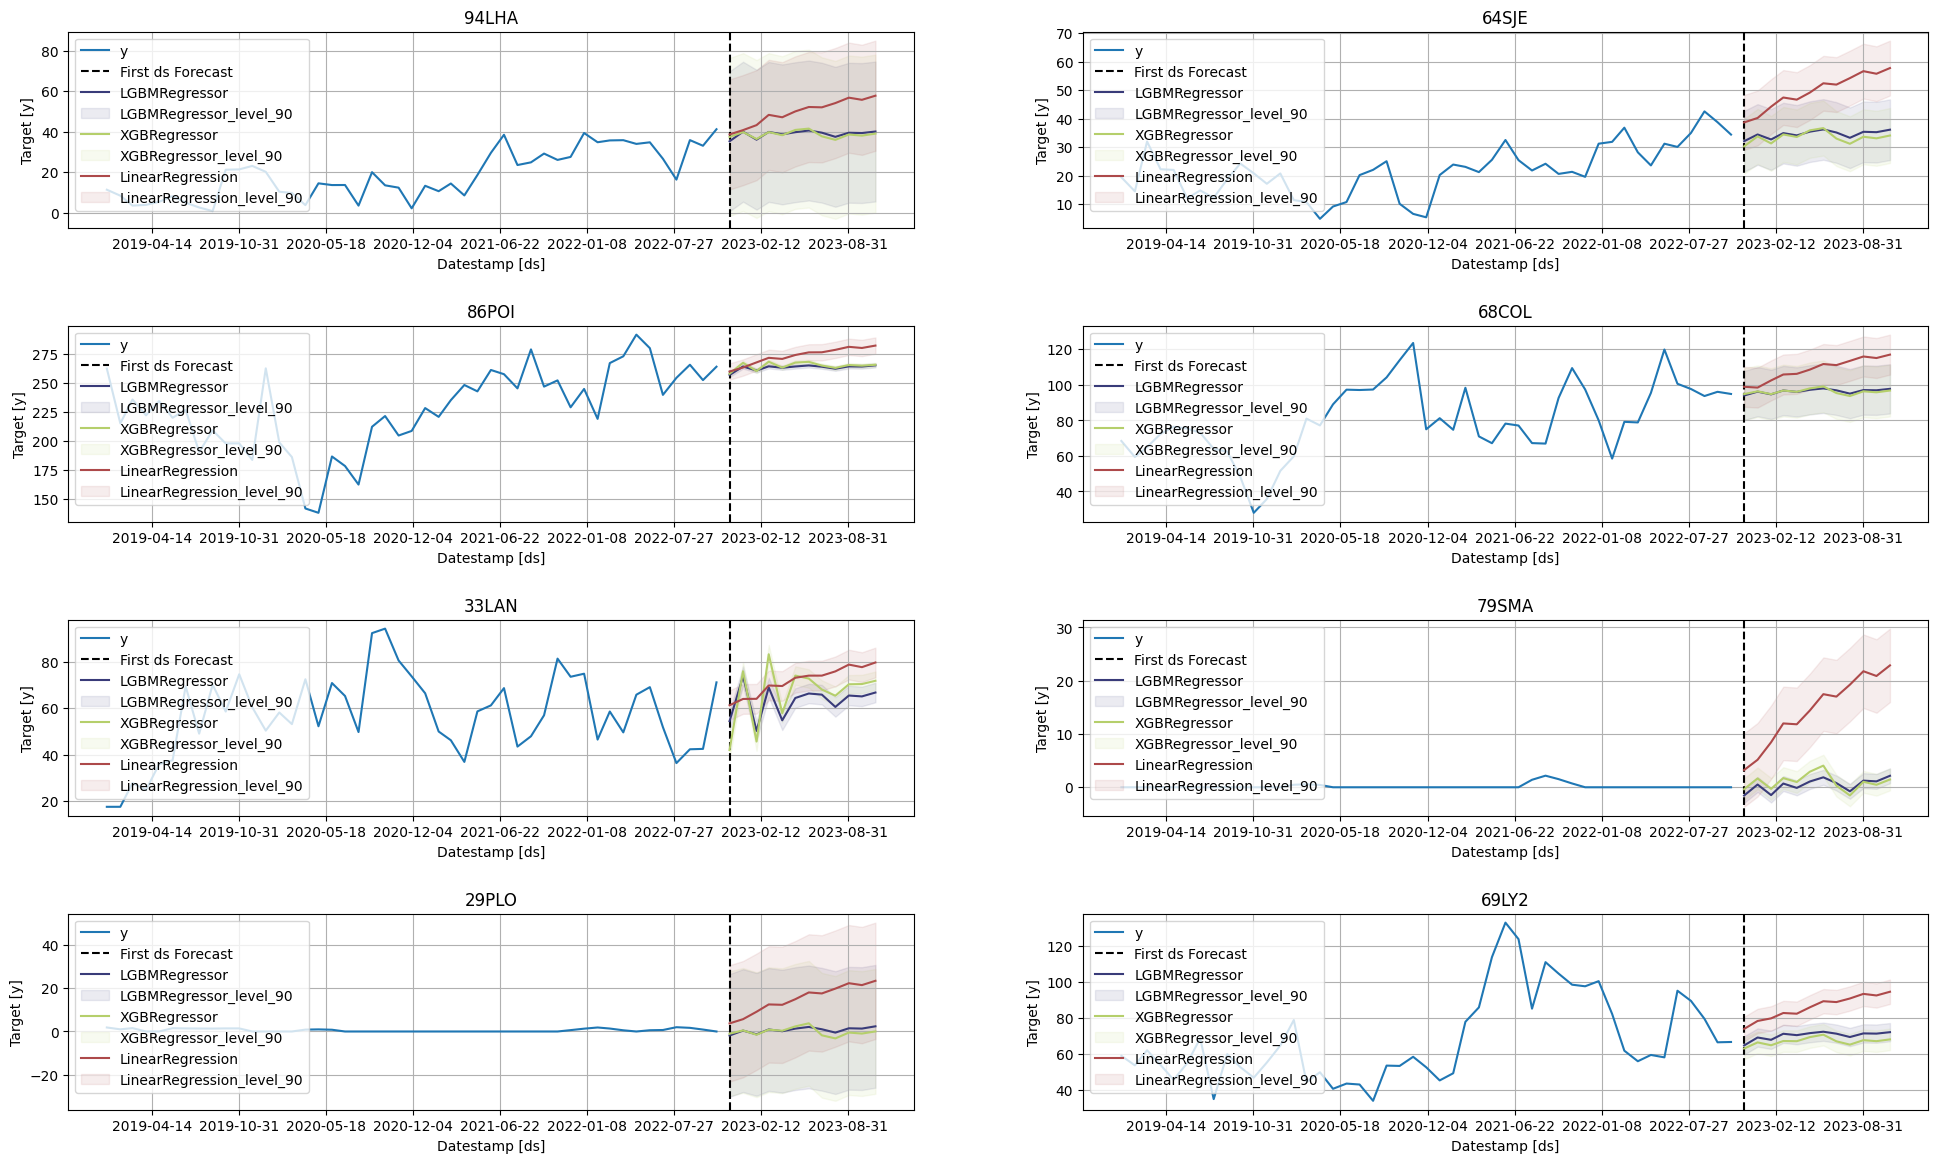

In [14]:
sf.plot(df_nixtla, fcst_mlf_df, engine='matplotlib')

In [15]:
# run time-series cross-validation:

cv_mlf_df = mlf.cross_validation(
    data=df_nixtla, 
    window_size=12, # represents h steps into the future that are being forecasted 
    n_windows=3, # number of windows used for cross-validation
    step_size=1, # step size between each window
    level=[90],
)

2021-09-01 00:00:00


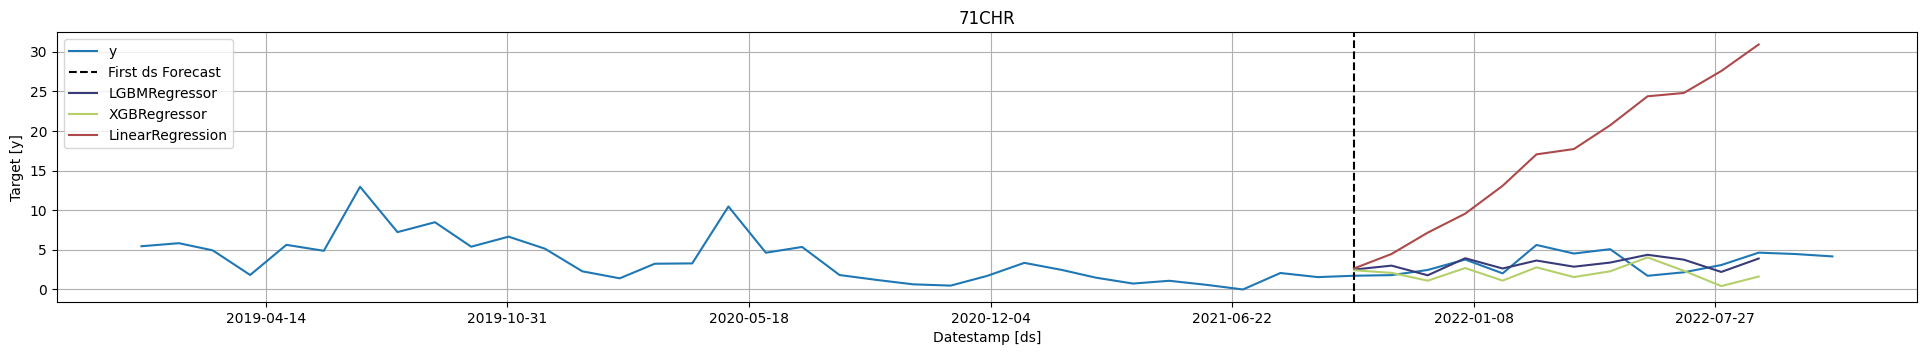

2021-10-01 00:00:00


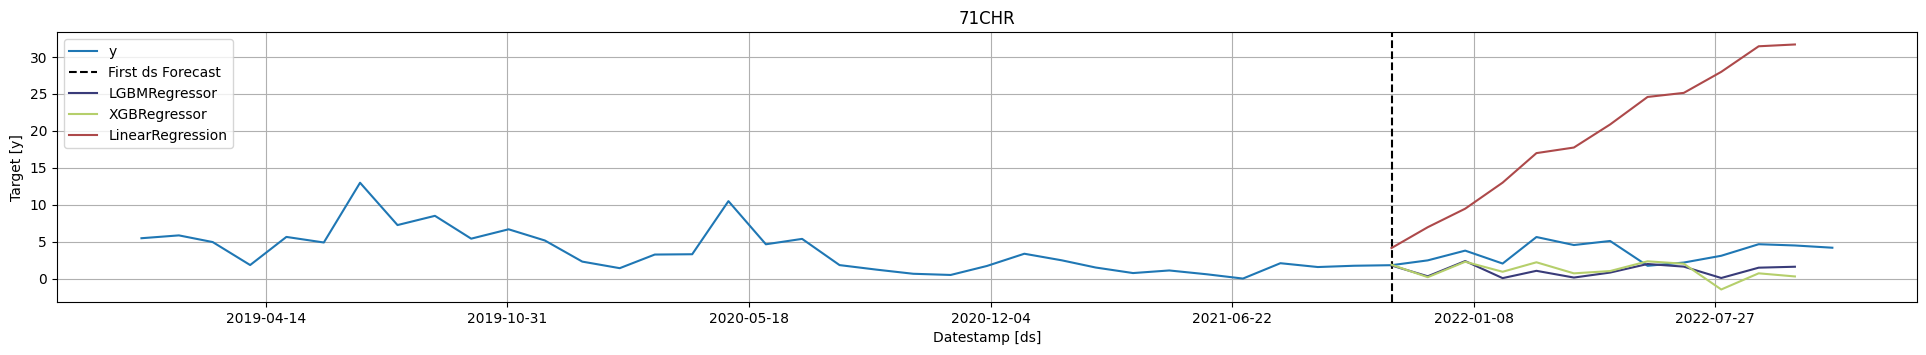

2021-11-01 00:00:00


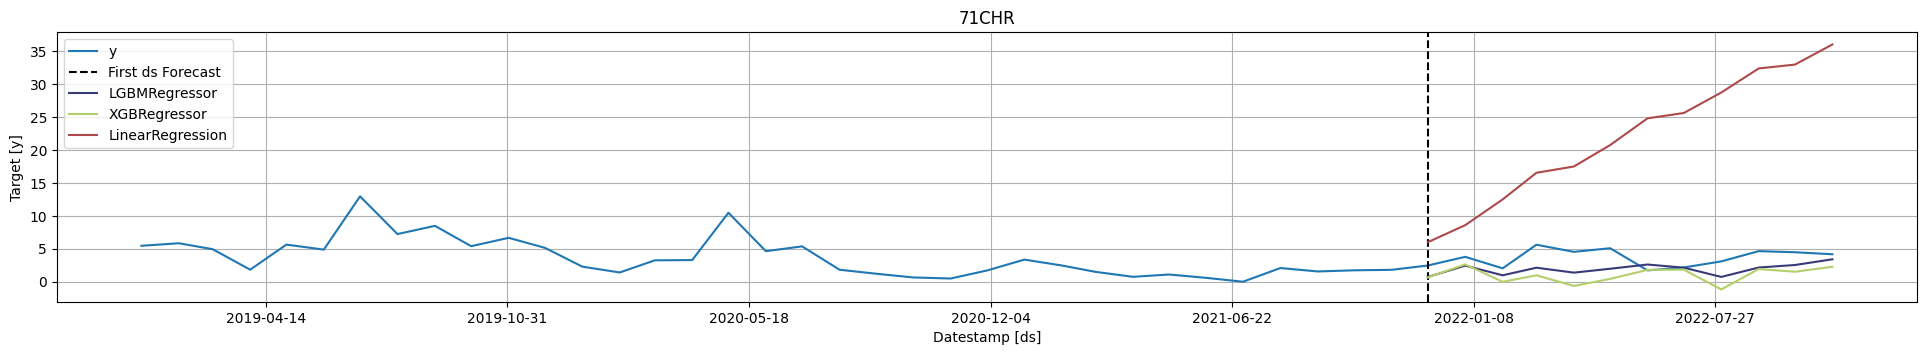

In [16]:
# analyse cross-validation results:

cutoffs = cv_mlf_df['cutoff'].unique()

for cutoff in cutoffs:
    print(cutoff)
    img2 = sf.plot(
        df_nixtla, 
        cv_mlf_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
        #cv_mlf_df.query('cutoff == "2022-04-01"').drop(columns=['y', 'cutoff']), 
        max_insample_length=400, 
        unique_ids=['71CHR'],
    )
    display(img2)

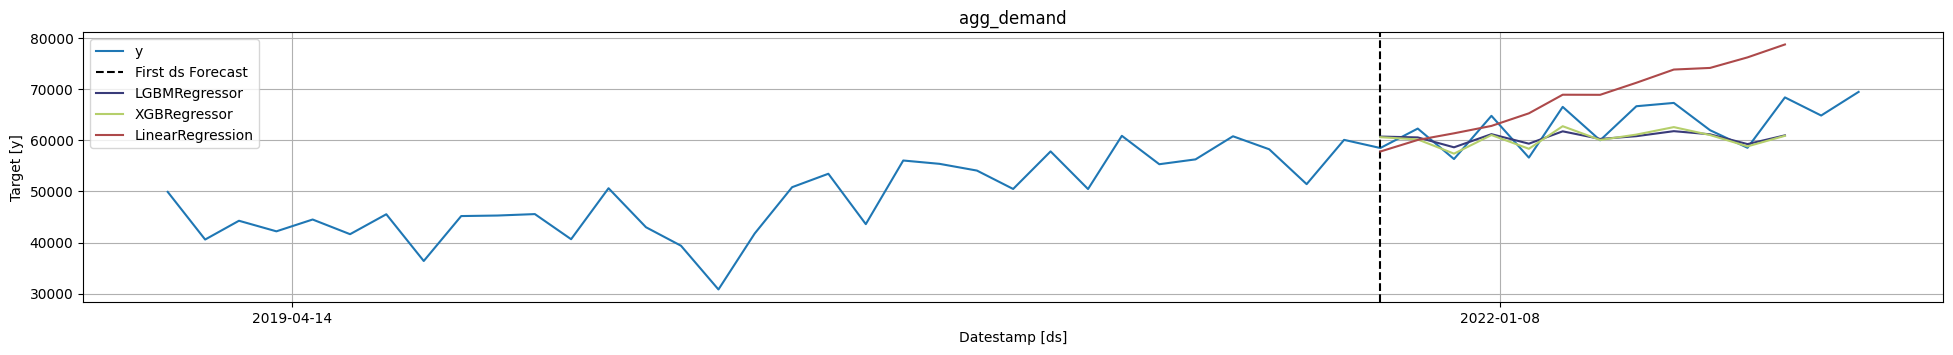

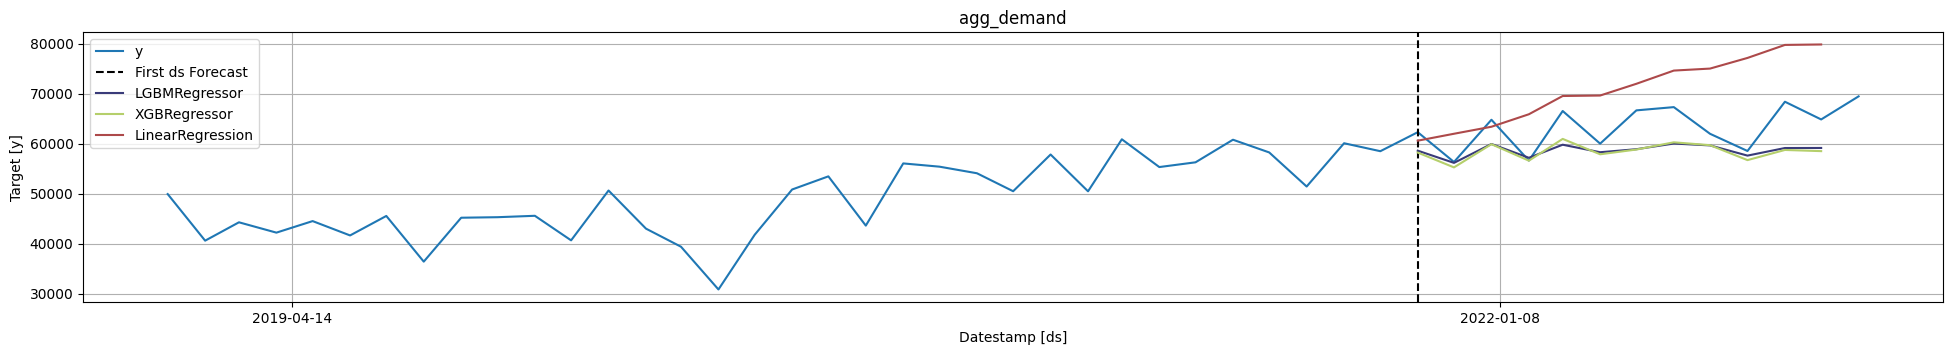

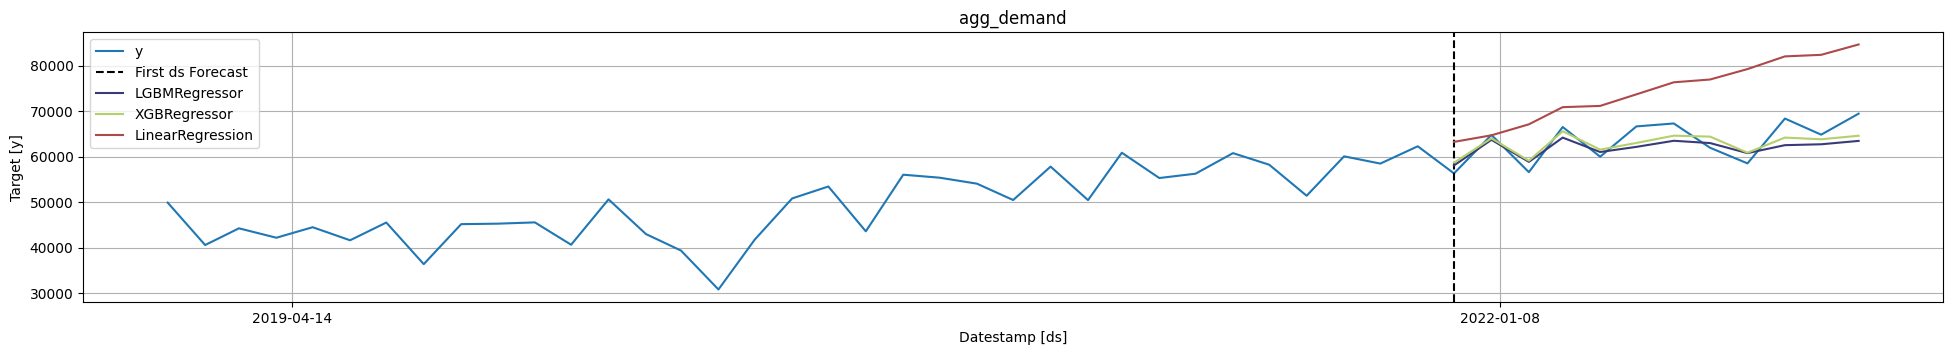

In [17]:
# aggregate demand:

agg_cv_df = cv_mlf_df.loc[:,~cv_mlf_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

agg_Y_df = df_nixtla.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

for cutoff in cutoffs:
    img = sf.plot(
        agg_Y_df, 
        agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
        max_insample_length=400,
    )
    display(img)

In [19]:
from typing import List, Callable

#from distributed import Client
#from fugue import transform
#from fugue_dask import DaskExecutionEngine
#from datasetsforecast.losses import mse, mae, smape

In [20]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [22]:
str_models = cv_mlf_df.loc[:, ~cv_mlf_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_mlf_df['cutoff'] = cv_mlf_df['cutoff'].astype(str)
cv_mlf_df['unique_id'] = cv_mlf_df['unique_id'].astype(str)